In [18]:
from time import time

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, vmap, jit, random
import optax
import matplotlib.pyplot as plt

from playground_jax.models import *

Goal: fit a scalar real-valued funciton
$ f: D \subset \mathbb{R} \rightarrow \mathbb{R}$

1. Generate training data

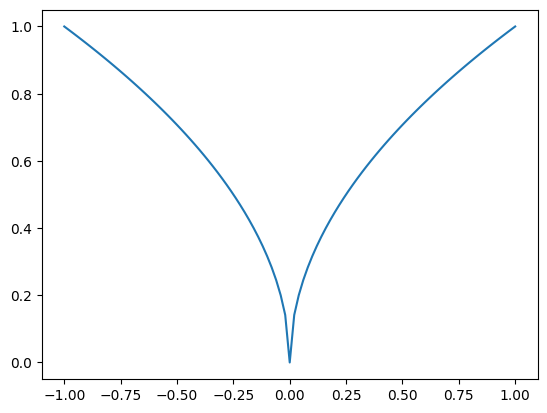

In [19]:
N = 101
x = jnp.expand_dims(jnp.linspace(-1, 1, N), axis=-1)
y = jnp.sqrt(jnp.abs(x))
#y = x**2
fig, ax = plt.subplots()
ax.plot(x, y)

2. build a model

In [20]:
# set a random key
key = random.PRNGKey(1)

params = init_mlp_params([1, 32, 1])

In [21]:
#jax.tree_map(lambda x: x.shape, params)

3. Define loss (mean square error loss)

In [22]:
def loss_fn(params, x, y):
    pred_y = vmap(forward, in_axes=(None, 0), out_axes=0)(params, x)
    return jnp.mean((y - pred_y) ** 2)

4. choose optimizer

In [23]:
lr = 1e-2
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(params)
#print(opt_state)

5. Update function

In [24]:
@jit
def update_fn(params, opt_state, x, y):
    loss, grads = value_and_grad(loss_fn)(params, x, y)

    # manula sgd update
    #params = jax.tree_map(lambda p, g: p - lr * g, params, grads)

    # optimizer update
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

6. Train

In [25]:
n_iter = int(1e4)
log_period_iter = int(1e3)
for i in range(n_iter):
    t0 = time()
    loss, params, opt_state = update_fn(params, opt_state, x, y)
    t1 = time()
    if i % log_period_iter == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

it: 0, loss: 2.302e+00, time: 0.1031s
it: 1000, loss: 7.324e-04, time: 0.0000s
it: 2000, loss: 3.722e-04, time: 0.0000s
it: 3000, loss: 2.432e-04, time: 0.0000s
it: 4000, loss: 1.687e-04, time: 0.0000s
it: 5000, loss: 1.301e-04, time: 0.0000s
it: 6000, loss: 1.082e-04, time: 0.0000s
it: 7000, loss: 8.705e-05, time: 0.0000s
it: 8000, loss: 7.716e-05, time: 0.0000s
it: 9000, loss: 6.887e-05, time: 0.0000s


7. Evaluate results

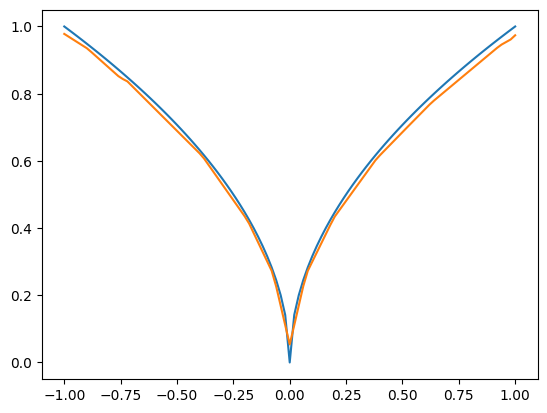

In [26]:
y_pred = vmap(forward, in_axes=(None, 0), out_axes=0)(params, x)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, y_pred)